Data: https://drive.google.com/file/d/1HneKy22aVGKYlSC8p4Cttd6-DKdFdY83/view?usp=sharing

Tutorial: https://github.com/jiuzhangjiangzuo/AICamp1.NLP

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_DIR = '/Users/songyihe/Documents/Study/AI_Projects/large-datasets/english-chinese/segmented_train_seg_by_word.txt'

# Load Data

In [3]:
SENTENCE_LEN = 5

In [4]:
eng_lines, ch_lines = [], []
with open(TRAIN_DIR) as file:
    num_line = 0
    for line in tqdm(file):
        num_line += 1
        if num_line % 2 == 1:
            eng_line = [i.lower() for i in line.strip('\n').split()]
            continue
        else:
            ch_line = [i for i in line.strip('\n').replace(' ', '')]
            
        if len(eng_line) <= SENTENCE_LEN and len(ch_line) <= SENTENCE_LEN:
            eng_lines.append(eng_line)
            ch_lines.append(ch_line)

20000000it [00:57, 345750.18it/s]


In [5]:
print(f'English Lines: {len(eng_lines)}')
print(f'Chinese Lines: {len(ch_lines)}')

English Lines: 103912
Chinese Lines: 103912


In [6]:
print(eng_lines[0])
print(ch_lines[0])

['deuces', 'the', 'winner', '.']
['一', '对', '二', '胜', '。']


# Build Vocab

In [7]:
from collections import Counter

In [8]:
eng_vocab, ch_vocab = [], []

for sentence in eng_lines:
    for word in sentence:
        eng_vocab.append(word)
        
for sentence in ch_lines:
    for word in sentence:
        ch_vocab.append(word)

In [9]:
print(f'Most Common English Word: {Counter(eng_vocab).most_common(10)}')
print(f'Most Common Chinese Word: {Counter(ch_vocab).most_common(10)}')

Most Common English Word: [('.', 49461), ('?', 14511), ('the', 10472), ('i', 10013), (',', 9489), ('!', 8807), ('you', 7493), ('a', 6860), ("'", 5555), ('it', 5524)]
Most Common Chinese Word: [('。', 44900), ('我', 15087), ('？', 14454), ('你', 9087), ('！', 8915), ('了', 8663), ('的', 8053), ('，', 7291), ('一', 6091), ('是', 5946)]


In [10]:
def add_word_to_dict(word2idx, idx2word, word):
    if word in word2idx:
        return
    index = len(word2idx)
    word2idx[word] = index
    idx2word[index] = word

In [11]:
spec_words = ['<eos>','<start>','<end>','<unk>']
eng_word2idx, eng_idx2word, ch_word2idx, ch_idx2word = {}, {}, {}, {}

for word in spec_words:
    add_word_to_dict(eng_word2idx, eng_idx2word, word)
    add_word_to_dict(ch_word2idx, ch_idx2word, word)
    
for word in set(eng_vocab):
    add_word_to_dict(eng_word2idx, eng_idx2word, word)
    
for word in set(ch_vocab):
    add_word_to_dict(ch_word2idx, ch_idx2word, word)

In [12]:
print(f'Size of English Dict: {len(eng_word2idx)}')
print(f'Size of Chinese Dict: {len(ch_word2idx)}')

Size of English Dict: 21743
Size of Chinese Dict: 4058


# Prepare Data

In [13]:
import tensorflow.compat.v1 as tf

In [14]:
data_x_in, data_y_in, data_y_out = [], [], []
data_x_len, data_y_len = [], []

for eng_line in eng_lines:
    indices = [eng_word2idx.get(word, eng_word2idx['<unk>'])for word in eng_line] + [eng_word2idx['<eos>']]
    data_x_in.append(indices)
    data_x_len.append(len(indices))
    
for ch_line in ch_lines:
    indices = [ch_word2idx.get(word, ch_word2idx['<unk>'])for word in ch_line]
    data_y_in.append([ch_word2idx['<start>']] + indices)
    data_y_out.append(indices + [ch_word2idx['<eos>']])
    data_y_len.append(len(indices) + 1)

In [15]:
print([eng_idx2word[idx] for idx in data_x_in[0]])
print([ch_idx2word[idx] for idx in data_y_in[0]])
print([ch_idx2word[idx] for idx in data_y_out[0]])

['deuces', 'the', 'winner', '.', '<eos>']
['<start>', '一', '对', '二', '胜', '。']
['一', '对', '二', '胜', '。', '<eos>']


In [16]:
data_x_in_pad = tf.keras.preprocessing.sequence.pad_sequences(data_x_in, padding='post', value=eng_word2idx['<eos>'])
data_y_in_pad = tf.keras.preprocessing.sequence.pad_sequences(data_y_in, padding='post', value=eng_word2idx['<end>'])
data_y_out_pad = tf.keras.preprocessing.sequence.pad_sequences(data_y_out, padding='post', value=eng_word2idx['<end>'])

data_x_len = np.asarray(data_x_len)
data_y_len = np.asarray(data_y_len)

In [17]:
print(f'data_x_in_pad shape: {data_x_in_pad.shape}')
print(f'data_y_in_pad shape: {data_y_in_pad.shape}')
print(f'data_y_out_pad shape: {data_y_out_pad.shape}')
print(f'data_x_len shape: {data_x_len.shape}')
print(f'data_y_len shape: {data_y_len.shape}')

data_x_in_pad shape: (103912, 6)
data_y_in_pad shape: (103912, 6)
data_y_out_pad shape: (103912, 6)
data_x_len shape: (103912,)
data_y_len shape: (103912,)


# Model

In [18]:
import tensorflow.compat.v1 as tf
import tensorflow_addons as tfa
from tensorflow.python.layers import core as layers_core

In [19]:
EMB_SIZE = 512   #word embedding vector length
HIDDEN_SIZE = 512        #hidden layer size
SRC_VOCAB_SIZE, TRG_VOCAB_SIZE = len(eng_word2idx), len(ch_word2idx)
SEQ_MAX_LEN = SENTENCE_LEN + 1
MAX_PRED_LEN = 10
MAX_GRAD = 1.0

In [20]:
rnn_graph = tf.Graph()
with rnn_graph.as_default():      
    ### Initializer
    initializer = tf.random_uniform_initializer(-0.08, 0.08)
    tf.get_variable_scope().set_initializer(initializer)
        
    ### Model Inputs
    x_in = tf.placeholder(dtype=tf.int32, shape=[None, None], name='x_in')
    x_len = tf.placeholder(dtype=tf.int32, shape=[None], name='x_len')
    y_in = tf.placeholder(dtype=tf.int32, shape=[None, None], name='y_in')
    y_out = tf.placeholder(dtype=tf.int32, shape=[None, None], name='y_out')
    y_len = tf.placeholder(dtype=tf.int32, shape=[None], name='y_len')
    lr = tf.placeholder(dtype=tf.float32, shape=[], name='lr')
        
    ### I.Embedding Layer
    embedding_encoder = tf.get_variable(name="embedding_encoder",
                                        shape=[SRC_VOCAB_SIZE, EMB_SIZE],
                                        dtype=tf.float32)
    embedding_decoder = tf.get_variable(name="embedding_decoder",
                                        shape=[TRG_VOCAB_SIZE, EMB_SIZE],
                                        dtype=tf.float32)
    # embedded_..._input: [-1, SEQ_LEN, EMB_SIZE]
    embedded_encoder_input = tf.nn.embedding_lookup(params=embedding_encoder, 
                                                    ids=x_in)
    embedded_decoder_input = tf.nn.embedding_lookup(params=embedding_decoder, 
                                                    ids=y_in)
        
    ### II.Encoder
    encoder_lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=HIDDEN_SIZE)
    # state: 2 * [batch_size, HIDDEN_SIZE] (2 for cell state and hidden state in LSTM)
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(cell=encoder_lstm_cell, 
                                                       inputs=embedded_encoder_input,
                                                       sequence_length=x_len,
                                                       time_major=False,
                                                       dtype=tf.float32)
        
    ### III.Decoder - Version for Training
    batch_size = tf.shape(x_in)[0]
    projection_layer = layers_core.Dense(len(ch_word2idx), use_bias=False)
    with tf.variable_scope("decode_layer"):
        sampler = tfa.seq2seq.TrainingSampler(time_major=False)
        sampler.initialize(embedded_decoder_input, y_len)
        decoder_lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=HIDDEN_SIZE)
        decoder = tfa.seq2seq.BasicDecoder(cell=decoder_lstm_cell, 
                                           sampler=sampler, 
                                           output_layer=projection_layer)
        outputs, _, _ = tfa.seq2seq.dynamic_decode(decoder=decoder,
                                                   decoder_init_input = embedded_decoder_input,
                                                   decoder_init_kwargs= {
                                                       'initial_state' : encoder_state,
                                                       'sequence_length': y_len
                                                   })      
        logits = outputs.rnn_output
        target_weights = tf.sequence_mask(y_len, SEQ_MAX_LEN, dtype=logits.dtype)
        
    ### III.Decoder - Version for Predicting
    with tf.variable_scope("decode_layer", reuse=True):
        sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder = tfa.seq2seq.BasicDecoder(decoder_lstm_cell, sampler, output_layer=projection_layer)       
        outputs, _ , __= tfa.seq2seq.dynamic_decode(decoder=decoder, 
                                                    maximum_iterations=MAX_PRED_LEN, 
                                                    decoder_init_input = embedding_decoder,
                                                    decoder_init_kwargs= {
                                                        'initial_state' : encoder_state,
                                                        'start_tokens': tf.fill([batch_size], ch_word2idx['<start>']), 
                                                        'end_token': ch_word2idx['<end>']
                                                    })
        translations = outputs.sample_id
    
    # Loss
    crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_out, logits=logits)
    loss = (tf.reduce_sum(crossentropy * target_weights) / tf.cast(batch_size, tf.float32))
        
    # Optimizer with Gradient Clip
    optimizer_origin = tf.train.GradientDescentOptimizer(learning_rate=lr)
    variables = tf.trainable_variables()
    gradients = tf.gradients(loss, variables)
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, MAX_GRAD)
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = optimizer_origin.apply_gradients(grads_and_vars=zip(clipped_gradients, variables),
                                                 global_step=global_step)
    
    # Show Trainable Variables
    print(*tf.trainable_variables(), sep='\n')

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'decode_layer_1/decoder/assert_greater/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/songyihe/opt/anaconda3/envs/ai_camp/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)  File "/Users/songyihe/opt/anaconda3/envs/ai_camp/lib/python3.6/site-packages/tensorflow/python/ops/check_ops.py", line 992, in assert_greater
    y, data, summarize, message, name)  File "/Users/songyihe/opt/anaconda3/envs/ai_camp/lib/python3.6/site-packages/tensorflow/python/ops/check_ops.py", line 373

# Train and Predict

In [21]:
BATCH_SIZE = 256

In [22]:
with tf.Session(graph=rnn_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # Train
    losses = []
    beginning_lr = 4
    for epoch in range(0,2):
        data_indices = np.asarray(list(range(len(data_x_in))))
        np.random.shuffle(data_indices)      
        for index in tqdm(range(0, len(data_indices), BATCH_SIZE)):
            batch_indices = data_indices[index: index+BATCH_SIZE]
            batch_lr = beginning_lr if epoch < 20 else beginning_lr * 0.5 ** (one_epoch - 20)
            _, batch_loss = sess.run([optimizer, loss],
                                     feed_dict={
                                         x_in: data_x_in_pad[batch_indices],
                                         y_in: data_y_in_pad[batch_indices],
                                         y_out: data_y_out_pad[batch_indices],
                                         x_len: data_x_len[batch_indices],
                                         y_len: data_y_len[batch_indices],
                                         lr: batch_lr})
            losses.append(batch_loss)
            
    # Predict for a Sample
    sample_sentence = 'eat food'
    indices = [eng_word2idx[i.lower()] for i in sample_sentence.split()]
    batch_x_in = np.asarray([indices])
    batch_x_len = np.asarray([len(indices)])
    traslation = sess.run(translations, feed_dict={
        x_in: batch_x_in,
        x_len: batch_x_len,
    })[0]
    print([ch_idx2word[i] for i in traslation])

100%|██████████| 406/406 [04:30<00:00,  1.50it/s]

['一', '起', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']


<AxesSubplot:>

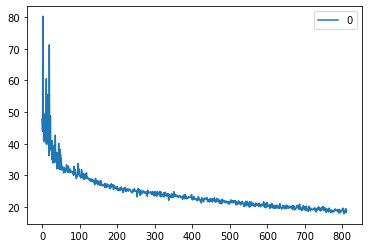

In [23]:
pd.DataFrame(losses).plot()